In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys
import math
import json
import re

hf = "/home"
sys.path.append(hf+"/will/projects/legoproj")
sys.path.append(hf+"/will/projects/training/dataprep")

import feature_utils as fu
from cvscripts import cv_utils as cvu

%matplotlib inline

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = Session(config=config)

import keras
from keras.models import load_model


def getObjFromHue(hue,dset):
    hue = int(round(hue/5))
    name = dset["ids"][str(hue)]
    return name


def getObjectsData(dset):
    
    objsdata = {}
    for entry in dset["ids"]:

        if entry == "0":
            continue

        name = dset["ids"][entry]
        objentry = dset["objects"][name]

        #print(objentry)

        l2w = fu.matrix_from_string(objentry["modelmat"])
        w2l = np.linalg.inv(l2w)

        bbl = np.array(objentry["bbl"])
        bbh = np.array(objentry["bbh"])

        dims = bbh - bbl

        info = {}
        info["w2l"] = w2l
        info["lows"] = bbl

        info["dims"] = dims
        info["name"] = dset["ids"][entry]

        objsdata[name] = info
        
    return objsdata


def separate(mask):
    
    kernel = np.ones((2,2), np.uint8) 
    maskdict = {}

    hsvmask = cv2.cvtColor(mask,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsvmask],[0],None,[180],[0,179])
    
    hues=[]
    for j,e in enumerate(hist):
        if e[0] > 100:
            hues.append(j)

    for hue in hues:

        threshed = cv2.inRange(hsvmask, (hue-1,2,100), (hue+1,255,255))
        threshed = cv2.medianBlur(threshed.astype(np.uint8), 3)
        threshed = cv2.dilate(threshed, kernel, iterations=1)

        #if np.sum(threshed) <= 255*100:
            #continue;

        maskdict[hue] = threshed

    return maskdict


kernel = np.ones((3,3),np.uint8)

In [12]:
index = 1
datapath = "/home/will/projects/legoproj/data/kpts_dset_{}/".format(index)
data = fu.dictFromJson(datapath + "dset.json")

objsdata = getObjectsData(data)

mtx = np.load(hf+"/will/projects/legoproj/cvscripts/calib_data/" + "camins.npy")

std_model = load_model("/home/will/projects/legoproj/nets/tst_trueu_bayes.h5",compile=False)
wing_model = load_model("/home/will/projects/legoproj/nets/tst_trueu_bayes_wing.h5",compile=False)

In [13]:
def generatePrediction(i):

    tag = "{:0>4}".format(i)

    img = cv2.imread(datapath + "{}_a.png".format(tag))
    
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_in = cv2.resize(img_in,(256,256),interpolation=cv2.INTER_LINEAR)
    
    #geomraw = cv2.imread(datapath + "geom/{}_geom.png".format(tag))

    pred = std_model.predict( np.reshape(img_in, (1,256,256,1)).astype('float32')/255.0 )
    pred = (255.0 * np.reshape((1.0+pred)/2.0, (256,256,4)))

    wingpred = wing_model.predict( np.reshape(img_in, (1,256,256,1)).astype('float32')/255.0 )
    wingpred = (255.0 * np.reshape((1.0+wingpred)/2.0, (256,256,4)))

    geom_pred = pred[:,:,0:3].astype(np.uint8)
    geom_pred_wing = wingpred[:,:,0:3].astype(np.uint8)

    maskpath = datapath + "{}_masks.png".format(tag)
    mask = cv2.imread(maskpath)
    masks = cvu.separate(mask)

    names = []

    for hue in masks:
        objname = getObjFromHue(hue,data)

        if objname:
            objclass = objname.split(".")[0]
            names.append(tuple([objname,hue]))
            
    return names, geom_pred, geom_pred_wing, img, masks

Pole.006 with 91 inliers
Engine.002 with 1100 inliers
Pole.003 with 647 inliers
Pole.005 with 459 inliers
Engine.001 with 1304 inliers
WingR.001 with 2205 inliers
Cockpit.001 with 607 inliers
Pole.001 with 447 inliers


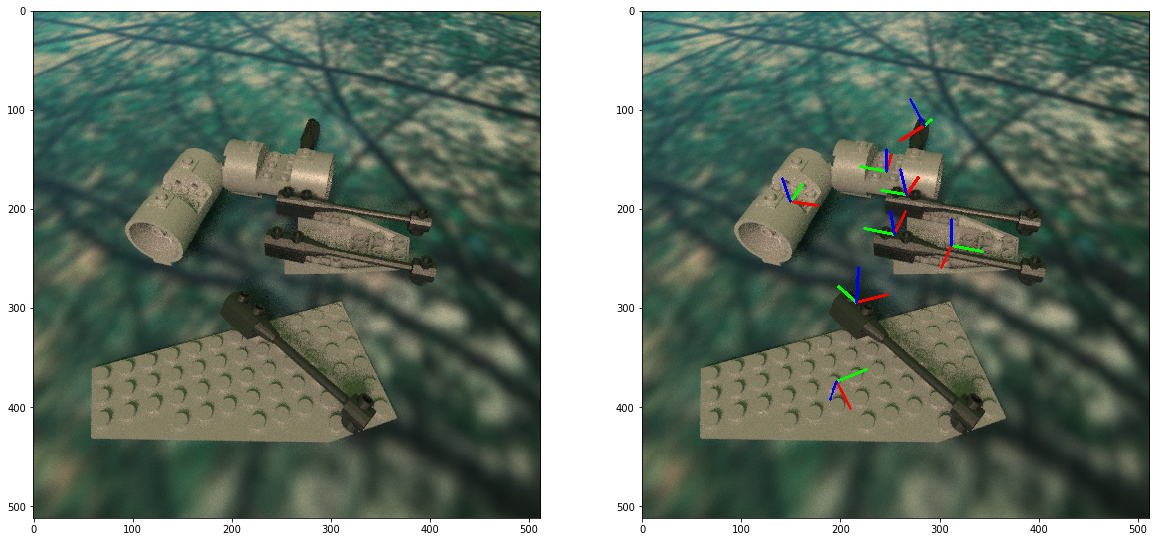

In [28]:
ind = 186
names, geom_pred, geom_pred_wing, img, masks = generatePrediction(ind)
imgdup = img.copy()
inds = np.dstack(np.meshgrid(np.arange(256), np.arange(256)))

for obj in names:
    
    name, hue = obj[0], obj[1]
    
    geompred = geom_pred 
        
    if "Wing" in name:
        geompred = geom_pred_wing
   
    dims = objsdata[name]["dims"]
    bbl = objsdata[name]["lows"]
    
    objmask = cv2.resize(masks[hue], (256,256), cv2.INTER_LINEAR)
    #objmask = cv2.erode(objmask,kernel,iterations = 1)

    geompred = cv2.resize(geompred, (256,256), cv2.INTER_LINEAR)
    
    region = cv2.bitwise_and(geompred,geompred,mask=objmask)
    #region = cv2.bitwise_and(geomraw,geomraw,mask=objmask)
    
    thresh = objmask > 250
    coords = (bbl[2::-1] + dims[2::-1] * (region[thresh]/255))
    
    locs = 2*inds[thresh]
    
    #temp = np.ones((coords.shape[0],4),dtype=np.float32)
    #temp[:,2::-1] = coords
    #temp[:,3] = 1.0
    #coords = temp
    
    coords =  np.insert(coords[:,2::-1],3, 1.0, axis=-1) 

    coords = coords[:,0:3]
    locs = locs[:,0:2]

    ret, rvec, tvec, inliers = cv2.solvePnPRansac(coords.astype(np.float32), locs.astype(np.float32), mtx, None, flags=(cv2.SOLVEPNP_EPNP),reprojectionError=5,iterationsCount=1700)
    print("{} with {} inliers".format(name,len(inliers)))
    
    axes, j1 = cv2.projectPoints(np.array([(0,0.0,0.0),(0.5, 0.0, 0.0),(0.0, 0.5, 0.0), (0.0, 0.0, 0.5)]), rvec, tvec, mtx, None)
    pt, j2 = cv2.projectPoints(coords.astype(np.float32), rvec, tvec, mtx, None)

    axes = np.array(axes,dtype=np.int32)[:,0,:]
    pt = np.array(pt,dtype=np.int32)[:,0,:]

    
    lines = [(255,0,0), (0,255,0), (0,0,255)]
    #for point in pt[::100]:
    #    cv2.circle(imgdup, (int(point[0]), int(point[1])), 5, (255, 255, 255), 1)

    obj_origin = tuple(axes[0])
    i = 0
    for point in axes[1:4]:
        cv2.line(imgdup, obj_origin, tuple(point), lines[i], 2)
        i+=1


fig=plt.figure(figsize=(20, 20))  
    
fig.add_subplot(1, 2, 1)
plt.imshow(img)

fig.add_subplot(1, 2, 2)
plt.imshow(imgdup)
    
plt.show()

In [5]:
'''
axes, _ = cv2.projectPoints(np.array([(0,0.0,0.0),(1.0, 0.0, 0.0),(0.0, 1.0, 0.0),(0.0, 0.0, 1.0)]), rvec, tvec, mtx, dist)
pt, _ = cv2.projectPoints(coords.astype(np.float32), rvec, tvec, mtx, dist)

axes = np.array(axes,dtype=np.int32)[:,0,:]
pt = np.array(pt,dtype=np.int32)[:,0,:]

#img3 = cv2.imread(datapath + "{}_a.png".format(tag))        


lines = [(255,0,0), (0,255,0), (0,0,255)]

i = 0
obj_origin = tuple(axes[0])

for point in pt[::25]:
    cv2.circle(img3, (int(point[0]), int(point[1])), 5, (255, 255, 255), 1)
    
for point in axes[1:4]:
    cv2.line(img3, obj_origin, tuple(point), lines[i], 3)
    i+=1
    
fig=plt.figure(figsize=(10, 10))  
plt.imshow(img3)
plt.show()
'''

'\naxes, _ = cv2.projectPoints(np.array([(0,0.0,0.0),(1.0, 0.0, 0.0),(0.0, 1.0, 0.0),(0.0, 0.0, 1.0)]), rvec, tvec, mtx, dist)\npt, _ = cv2.projectPoints(coords.astype(np.float32), rvec, tvec, mtx, dist)\n\naxes = np.array(axes,dtype=np.int32)[:,0,:]\npt = np.array(pt,dtype=np.int32)[:,0,:]\n\n#img3 = cv2.imread(datapath + "{}_a.png".format(tag))        \n\n\nlines = [(255,0,0), (0,255,0), (0,0,255)]\n\ni = 0\nobj_origin = tuple(axes[0])\n\nfor point in pt[::25]:\n    cv2.circle(img3, (int(point[0]), int(point[1])), 5, (255, 255, 255), 1)\n    \nfor point in axes[1:4]:\n    cv2.line(img3, obj_origin, tuple(point), lines[i], 3)\n    i+=1\n    \nfig=plt.figure(figsize=(10, 10))  \nplt.imshow(img3)\nplt.show()\n'

In [6]:
import scipy
from scipy.spatial.transform import Rotation as R
import inspect

tvec = np.array(tvec[:,0],dtype=np.float32) * np.array([1.0,-1.0,-1.0])
rvec = np.array(rvec[:,0],dtype=np.float32)

print("OpenCV tvec = {}".format( tvec ))

orig = np.array([0.0,0.0,0.0,1.0],dtype=np.float32)

mv = np.matmul(viewmat,modelmat)
camerapos = np.matmul(mv,orig)

#print("\nBlender camerapos mat = \n{}\n".format(mv))
print("Blender tvec = {}\n\n==============================================================".format(camerapos[0:3]))


#print("\nOpenCV rvec = {}\n\n".format( rvec ))

cvrotmat = R.from_rotvec(np.array(rvec,dtype=np.float32))

blenderrotmat = mv[0:3,0:3]
brotmat = R.from_matrix(blenderrotmat)

bl_euler = np.array(brotmat.as_euler('xyz', degrees=True),dtype=np.float32)
cv_euler = np.array(cvrotmat.as_euler('xyz', degrees=True),dtype=np.float32)

cv2bl = [1.0, -1.0, -1.0] * cv_euler + [180.0,0.0,0.0]

print("\nBlender rotmat = {}".format(bl_euler))
#print("OpenCV rotmat = \n{}\n".format(cv_euler))
print("Estimated rotmat = {}\n".format(cv2bl))

#print("Blender rotmat = \n{}\n".format(brotmat.as_rotvec()))
#print("OpenCV rotmat = \n{}\n".format(cvrotmat.as_rotvec()))


OpenCV tvec = [ 1.16799152  1.33843291 -9.03376675]


NameError: name 'viewmat' is not defined